# Sentiment Analysis of Amazon Product Reviews

For my final project, I want to look deeper into natural language processing. Even though we explored a natural language project earlier in this course, I wanted to improve my NLP work and look into more state of the art models.

- Revise some of the data cleaning operations performed on full text data that I performed in the disaster tweets mini-project
- Extend the classifier with more labels
- Investigate a transformer model, BERT, and compare it to the RNN model, LSTM
- Lastly, I wanted to compare these deep learning models to a traditional machine learning model, SVM

## Problem description

I am using the [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews) dataset from Kaggle. It contains more than 568k consumer reviews on different amazon products. These reviews come with a score of 1 to 5 stars.

The task is to build a model that will determine if a given review is positive (4 or 5 stars), negative (1 or 2 stars), or neutral (3 stars).

To do so, I am going to use an RNN approach and a Transformer-based approach. Long Short-Term Memory (LSTM) and Bidirectional Encoder Representations from Transformers (BERT), respectively. 

I picked these two because the RNN approach represents what we have reviewed in this course, but the transformer approach represents the current state of the art, and they each have different pros and cons.

An LSTM, when compared to transformer models like BERT, is lighter and easier to run on consumer hardware. However, training an LSTM can’t be parallelized well due to the step-by-step nature so it can be slow on large datasets.

BERT is a pre-trained transformer model, so it already knows language structure, and it's bidirectional so it can pick up on nuances better than an LSTM. However, it requires significant computing power for training and inference. Selecting the correct base model and tuning hyperparameters just so I could run it on my hardware was a long, iterative process. 

### Setup Code

In [11]:
# !pip install pandas seaborn matplotlib wordcloud nltk emoji scikit-learn tensorflow torch transformers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud

import re
import string
import time
import random
import html
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

In [13]:
# !kaggle datasets download arhamrumi/amazon-product-reviews
# !unzip -o amazon-product-reviews.zip -d reviews_data

In [33]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

## Exploratory Data Analysis

For the dataset, there were hardly any empty values. The columns "ProfileName" and "Summary" had missing values. Each had about 25 null entries out of over 568,000 records. But since I wasn't planning on using those columns, I left those entries alone in the dataset and focused on "Score" and "Text."

Score broke down with 5 star reviews being the predominant value with over 363,000 followed by a score of 4 stars having over 80,000 and scores 1 and 2 summed up to around 82,000, the total with a score of 3 was around 42,000. The data set was greatly unbalanced.

And when reviewing the text, I noticed there were some emojis being used so this needed to be addressed. An words like "BR" coming up often in frequency plots which suggest that there are some HTML tags in the text, so this led me to add more processing to my data cleaning pipeline.

For my data cleaning pipeline I first lowercase all the text and then ran the text through an HTML on a escaper function and I pulled in the emoji package so that I could emoji the text. Next, I removed all the numbers and replaced punctuations with spaces and to further reduce the unique word count. 

I found a lot of words like "im" and "u" in in the frequency chart, so I also decided to remove all words with fewer than three characters. Lastly, I ran each word through a lemmatizer to take instances of words like "runs," "running," and "run" and make them just "run." I saved the cleaned up text as "text_clean."

I iterated on the cleanup process a few more times removing words that appeared frequently in all categories and offered little semantic distinction because of it.

Then I transformed the score into a new column called "sentiment" with the following mapping:

- positive (4 or 5 stars)
- neutral (3 stars)
- negative (1 or 2 stars)


In [15]:
stop_words = set(stopwords.words('english'))
stop_words.update(['like', 'one', 'would', 'get', 'make', 'really', 'much', 'time', 'product', 'amazon', 'buy', 'bag', 'box'])

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = html.unescape(text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)

    tokens = word_tokenize(text)

    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) >= 3
    ]

    return " ".join(cleaned_tokens)

In [16]:
reviews_df = pd.read_csv("reviews_data/Reviews.csv")
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [17]:
print(reviews_df.shape)
reviews_df.info()
reviews_df.isnull().sum()
reviews_df['Score'].value_counts()

(568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [18]:
def map_sentiment(score):
    if score in [1, 2]:
        return 'negative'
    elif score == 3:
        return 'neutral'
    elif score in [4, 5]:
        return 'positive'

reviews_df['sentiment'] = reviews_df['Score'].apply(map_sentiment)

<Axes: xlabel='sentiment'>

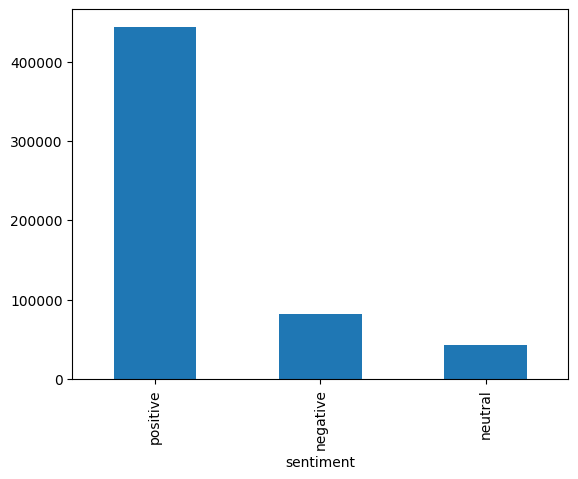

In [19]:
reviews_df['sentiment'].value_counts().plot(kind='bar')

In [20]:
reviews_df['clean_text'] = reviews_df['Text'].apply(clean_text)
reviews_df['text_len'] = reviews_df['clean_text'].apply(lambda x: len(x.split()))

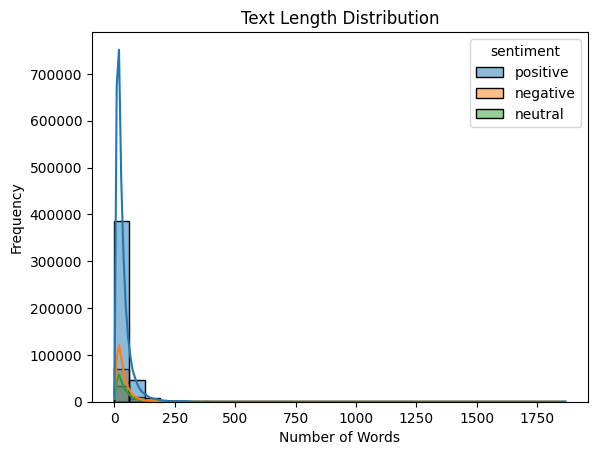

In [21]:
sns.histplot(data=reviews_df, x='text_len', hue='sentiment', bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

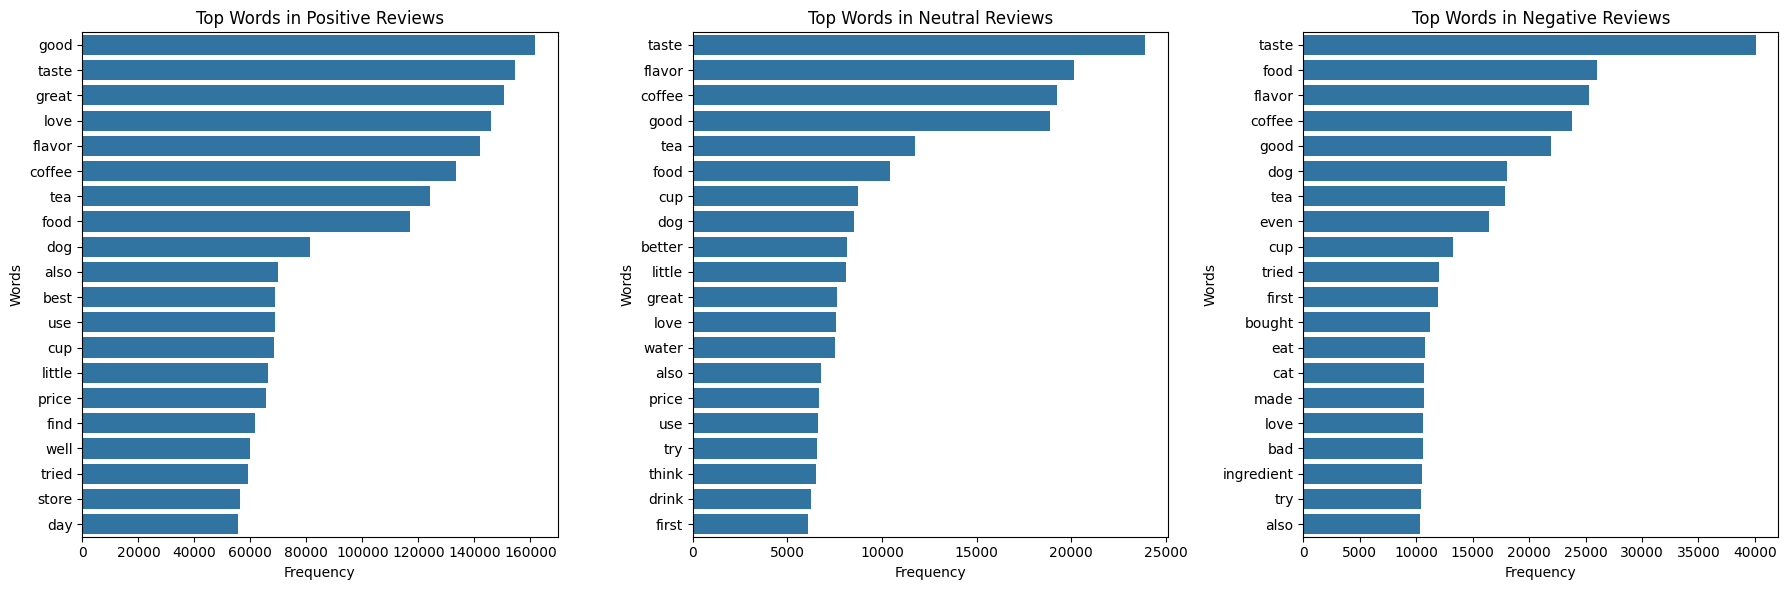

In [22]:
def plot_common_words(target_value, title, ax):
    texts = reviews_df[reviews_df['sentiment'] == target_value]['clean_text']
    all_words = ' '.join(texts).split()
    common_words = Counter(all_words).most_common(20)

    words, counts = zip(*common_words)
    sns.barplot(x=list(counts), y=list(words), ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_common_words("positive", "Top Words in Positive Reviews", ax=axes[0])
plot_common_words("neutral", "Top Words in Neutral Reviews", ax=axes[1])
plot_common_words("negative", "Top Words in Negative Reviews", ax=axes[2])

plt.tight_layout()
plt.show()

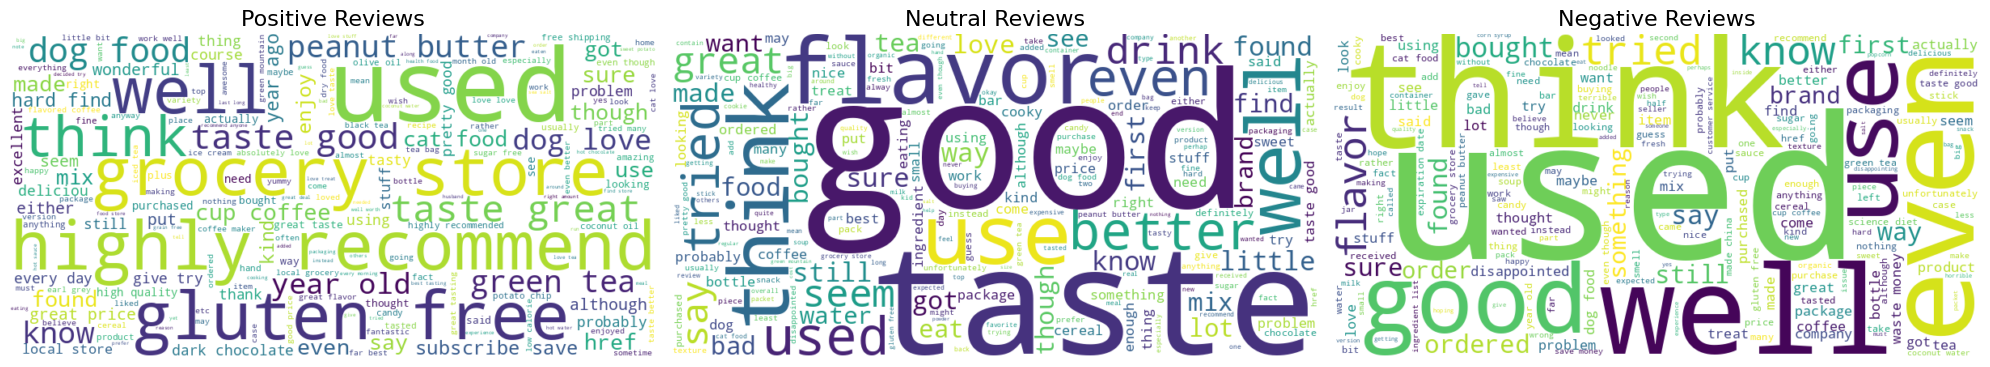

In [23]:
def show_wordcloud(target_value, title, ax):
    text = ' '.join(reviews_df[reviews_df['sentiment'] == target_value]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=16)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

show_wordcloud("positive", "Positive Reviews", ax=axes[0])
show_wordcloud("neutral", "Neutral Reviews", ax=axes[1])
show_wordcloud("negative", "Negative Reviews", ax=axes[2])

plt.tight_layout()
plt.show()

## Analysis (model building and training)

For this project, I implemented three different approaches to sentiment analysis: a traditional supervised learning algorithm, [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine), a deep learning recurrent neural network, [Long Short-Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), and a transformer-based model, [Bidirectional Encoder Representations from Transformers (BERT)](https://en.wikipedia.org/wiki/BERT_(language_model)).

I selected LSTM because it is a technique we explored in the *Intro to Deep Learning* course, and BERT because, in the context of natural language processing, it represents a significant evolution beyond RNNs in terms of context awareness and performance. Finally, I included SVM as a baseline model to compare the computational efficiency and accuracy of deep learning methods against a classic machine learning approach.

Before building the models, I first created a more balanced dataset. This also gave me control over how many samples of each sentiment type I wanted to include in the training process. 

One of my initial concerns was that I might not have enough compute power to handle a large volume of data, so having the option to limit the number of records used for training and inference allowed me to build and test the modeling pipeline for each approach incrementally.

### Sampled Data

I began with 4,000 randomly selected records for each sentiment category (positive, neutral, and negative resulting in a balanced working dataset. I then split this dataset into 80% for training and 20% for testing.

In [24]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

MAX_N_PER_LABEL = 4000

print("\nOriginal value counts:")
print(reviews_df['sentiment'].value_counts())

sampled_df = reviews_df.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=min(MAX_N_PER_LABEL, len(x)), random_state=SEED)
)

sampled_df = sampled_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(sampled_df['sentiment'].value_counts())


Original value counts:
sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64
sentiment
negative    4000
neutral     4000
positive    4000
Name: count, dtype: int64


/var/folders/d9/d4l391w163sd5w0r0vcdlpkr0000gn/T/ipykernel_84322/1808545405.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = reviews_df.groupby('sentiment', group_keys=False).apply(


In [25]:
X = sampled_df['clean_text']
y = sampled_df['sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
target_names = label_encoder.classes_
print(f"Label mapping: {dict(zip(label_encoder.transform(target_names), target_names))}")
print(f"Number of classes: {num_classes}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Label mapping: {np.int64(0): 'negative', np.int64(1): 'neutral', np.int64(2): 'positive'}
Number of classes: 3
Training set size: 9600
Test set size: 2400


For each of the following models, I pulled out as many configuration and hyperparameters out to variables as I could.

And to compare the models, I tracked the total processing time, and saved the classification report to a variable. The classification report tracks the following: precision, recall and f1-score for each classification.

### Support Vector Machine

In [26]:
MAX_FEATURES = 10000
REGULARIZATION = 1.0
MAX_ITER = 1000

svm_start_time = time.time()

tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

svm_model = LinearSVC(random_state=SEED, C=REGULARIZATION, dual='auto', max_iter=MAX_ITER)

print("Training SVM model...")
svm_model.fit(X_train_tfidf, y_train)
print("Training complete.")

print("Evaluating model...")
y_pred = svm_model.predict(X_test_tfidf)

svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

print(f"SVM Classification Report:")
svm_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
svm_report_df = pd.DataFrame(svm_report).transpose()
print(svm_report_df)

svm_cm = confusion_matrix(y_test, y_pred)

svm_end_time = time.time()
svm_time = time.strftime('%H:%M:%S', time.gmtime(svm_end_time - svm_start_time))
print(f"SVM total processing time: {svm_time}")

TF-IDF Features: 10000
Training SVM model...
Training complete.
Evaluating model...
SVM Accuracy: 0.6637
SVM Classification Report:
              precision   recall  f1-score     support
negative       0.660826  0.66000  0.660413   800.00000
neutral        0.594524  0.57000  0.582004   800.00000
positive       0.730216  0.76125  0.745410   800.00000
accuracy       0.663750  0.66375  0.663750     0.66375
macro avg      0.661855  0.66375  0.662609  2400.00000
weighted avg   0.661855  0.66375  0.662609  2400.00000
SVM total processing time: 00:00:00


### Long Short-Term Memory

In [ ]:
VOCAB_SIZE_LIMIT = 20000  # Max number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 100 # Max length of input sequences (pad/truncate)
EMBEDDING_DIM = 64        # Dimension of word embeddings
LSTM_UNITS = 64           # Number of units in the LSTM layer
BATCH_SIZE = 64           # Batch size for training
EPOCHS = 10               # Max number of training epochs

lstm_start_time = time.time()

tokenizer = Tokenizer(num_words=VOCAB_SIZE_LIMIT, oov_token='<OOV>')

# Fit the tokenizer ONLY on the training data
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1 # +1 for padding token 0
print(f"Effective vocabulary size: {vocab_size} (limited by num_words={VOCAB_SIZE_LIMIT})")

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_train.shape[1]

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(f"Padded sequence length: {MAX_SEQUENCE_LENGTH}")

print("Building LSTM model...")
model = Sequential([
    # Embedding layer: Maps integer sequences to dense vectors
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),

    # Spatial Dropout: Drops entire 1D feature maps to prevent overfitting in NLP tasks
    SpatialDropout1D(0.2),

    # LSTM layer: Processes sequential information
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),

    # Using softmax activation for multi-class classification instead of sigmoid
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


print("Training LSTM model...")
history = model.fit(X_train_padded, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_padded, y_test),
                    verbose=2)
print("Training complete.")

print("Evaluating model...")
lstm_loss, lstm_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_int = np.argmax(y_test, axis=1)

print(f"LSTM Classification Report:")
lstm_report = classification_report(y_test_int, y_pred, target_names=target_names, output_dict=True)
lstm_report_df = pd.DataFrame(lstm_report).transpose()
print(lstm_report_df)

lstm_cm = confusion_matrix(y_test_int, y_pred)

lstm_end_time = time.time()
lstm_time = time.strftime('%H:%M:%S', time.gmtime(lstm_end_time - lstm_start_time))
print(f"LSTM total processing time: {lstm_time}")

Effective vocabulary size: 17342 (limited by num_words=20000)
Padded sequence length: 100
Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/10
150/150 - 4s - 25ms/step - accuracy: 0.3361 - loss: 1.0993 - val_accuracy: 0.3554 - val_loss: 1.0974
Epoch 2/10
150/150 - 3s - 21ms/step - accuracy: 0.3518 - loss: 1.0966 - val_accuracy: 0.3562 - val_loss: 1.0961
Epoch 3/10
150/150 - 3s - 21ms/step - accuracy: 0.3541 - loss: 1.0867 - val_accuracy: 0.3529 - val_loss: 1.0916
Epoch 4/10
150/150 - 3s - 22ms/step - accuracy: 0.3810 - loss: 1.0666 - val_accuracy: 0.3579 - val_loss: 1.0987
Epoch 5/10
150/150 - 3s - 21ms/step - accuracy: 0.3899 - loss: 1.0436 - val_accuracy: 0.3608 - val_loss: 1.1059
Epoch 6/10
150/150 - 3s - 21ms/step - accuracy: 0.3803 - loss: 1.0347 - val_accuracy: 0.3633 - val_loss: 1.1178
Epoch 7/10
150/150 - 3s - 21ms/step - accuracy: 0.3874 - loss: 1.0325 - val_accuracy: 0.3500 - val_loss: 1.0992
Epoch 8/10
150/150 - 3s - 22ms/step - accuracy: 0.3877 - loss: 1.0272 - val_accuracy: 0.3508 - val_loss: 1.1174
Epoch 9/10
150/150 - 3s - 21ms/step - accuracy: 0.4016 - loss: 1.0112 - val_accur

### BERT

In [ ]:
# BERT_MODEL_NAME = 'bert-base-uncased' # Original BERT model
BERT_MODEL_NAME = 'distilbert-base-uncased' # Using DistilBERT to save memory
MAX_LENGTH = 96                             # Reduced max length from 128 to save memory
BATCH_SIZE = 4                              # Reduced Batch size from 16 to save memory
LEARNING_RATE = 3e-5
EPOCHS = 3

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

bert_start_time = time.time()

print(f"Loading BERT tokenizer: {BERT_MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

print("Tokenizing data (returning lists)...")
# Tokenize all texts and convert to input IDs
encodings = tokenizer(
    X.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors=None # Let tokenizer return lists
)

# Manually convert lists to PyTorch tensors
print("Manually converting lists to PyTorch tensors...")
input_ids = torch.tensor(encodings['input_ids'], dtype=torch.long)
attention_mask = torch.tensor(encodings['attention_mask'], dtype=torch.long)
tensor_labels = torch.tensor(y_encoded, dtype=torch.long) # Also ensure labels are torch.long

# Data Splitting & DataLoader Creation
# Split into train, validation, and test sets (indices)
train_idx, test_val_idx = train_test_split(
    np.arange(len(input_ids)), test_size=0.2, random_state=SEED, stratify=y_encoded
)

 # Split rest into 50% test, 50% validation
test_idx, val_idx = train_test_split(
    test_val_idx, test_size=0.5, random_state=SEED, stratify=y_encoded[test_val_idx]
)

# Create TensorDatasets
train_dataset = TensorDataset(input_ids[train_idx], attention_mask[train_idx], tensor_labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_mask[val_idx], tensor_labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_mask[test_idx], tensor_labels[test_idx])

# Create DataLoaders using the updated BATCH_SIZE
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Using Batch Size: {BATCH_SIZE}")

print(f"Loading pre-trained BERT model for sequence classification: {BERT_MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

# Using AdamW because it is the recommended optimizer for BERT
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps for scheduler
total_steps = len(train_dataloader) * EPOCHS
# Create learning rate scheduler (this is still from transformers)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

print(f"Fine-tuning BERT model for {EPOCHS} epochs...")
is_distilbert = 'distilbert' in BERT_MODEL_NAME.lower() # Check if using DistilBERT

for epoch_i in range(0, EPOCHS):
    print(f'\n======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    print('Training...')
    epoch_start_time = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 400 == 0 and not step == 0:
            elapsed = time.strftime('%H:%M:%S', time.gmtime(time.time() - epoch_start_time))
            print(f'Batch {step:>5,} of {len(train_dataloader):>5,} - Elapsed: {elapsed}.')

        # Unpack batch, move tensors to the correct device
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device) # Labels are already tensors from manual conversion

        model.zero_grad() # Clear previously calculated gradients

        # Prepare model inputs - conditionally exclude token_type_ids
        model_inputs = {
            'input_ids': b_input_ids,
            'attention_mask': b_input_mask,
            'labels': b_labels
        }
        if not is_distilbert: # Only add token_type_ids if not DistilBERT
                model_inputs['token_type_ids'] = None

        # Perform forward pass using dictionary unpacking
        outputs = model(**model_inputs)

        loss = outputs.loss # Model automatically calculates loss when labels are provided
        total_train_loss += loss.item()

        loss.backward() # Perform backward pass to calculate gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradients to prevent exploding gradients

        optimizer.step() # Update parameters
        scheduler.step() # Update learning rate

    # Calculate average loss over training data
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.strftime('%H:%M:%S', time.gmtime(time.time() - epoch_start_time))
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Training epoch took: {training_time}")

    print("Running Validation...")
    model.eval() # Put model in evaluation mode
    total_eval_loss = 0
    all_preds = []
    all_labels = []

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device) # Labels are already tensors

        # Tell PyTorch not to compute gradients
        with torch.no_grad():
            # Prepare model inputs - conditionally exclude token_type_ids
            model_inputs = {
                'input_ids': b_input_ids,
                'attention_mask': b_input_mask,
                'labels': b_labels
            }
            if not is_distilbert: # Only add token_type_ids if not DistilBERT
                    model_inputs['token_type_ids'] = None

            # Perform forward pass using dictionary unpacking
            outputs = model(**model_inputs)

        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU for metrics calculation
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        all_preds.append(np.argmax(logits, axis=1).flatten())
        all_labels.append(label_ids.flatten())

print("Training complete.")

print("Evaluating model on the test set...")
model.eval()
all_preds = []
all_labels = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device) # Labels are already tensors

    with torch.no_grad():
        # Prepare model inputs - conditionally exclude token_type_ids
        # No labels passed during test prediction
        model_inputs = {
            'input_ids': b_input_ids,
            'attention_mask': b_input_mask
        }
        if not is_distilbert: # Only add token_type_ids if not DistilBERT
                model_inputs['token_type_ids'] = None

        # Perform forward pass using dictionary unpacking
        outputs = model(**model_inputs)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    all_preds.append(np.argmax(logits, axis=1).flatten())
    all_labels.append(label_ids.flatten())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
bert_accuracy = accuracy_score(all_labels, all_preds)
print(f"BERT Test Accuracy: {bert_accuracy:.4f}")

print(f"BERT Classification Report:")
bert_report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)
bert_report_df = pd.DataFrame(bert_report).transpose()
print(bert_report_df)

bert_cm = confusion_matrix(all_labels, all_preds)

bert_end_time = time.time()
bert_time = time.strftime('%H:%M:%S', time.gmtime(bert_end_time - bert_start_time))
print(f"BERT total processing time: {bert_time}")

Using MPS (Apple Silicon)
Loading BERT tokenizer: distilbert-base-uncased...
Tokenizing data (returning lists)...
Manually converting lists to PyTorch tensors...
Training set size: 9600
Validation set size: 1200
Test set size: 1200
Using Batch Size: 4
Loading pre-trained BERT model for sequence classification: distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT model for 3 epochs...

======== Epoch 1 / 3 ========
Training...
Batch   400 of 2,400 - Elapsed: 00:00:25.
Batch   800 of 2,400 - Elapsed: 00:00:50.
Batch 1,200 of 2,400 - Elapsed: 00:01:15.
Batch 1,600 of 2,400 - Elapsed: 00:01:40.
Batch 2,000 of 2,400 - Elapsed: 00:02:05.

  Average training loss: 0.8502
  Training epoch took: 00:02:30

Running Validation...

======== Epoch 2 / 3 ========
Training...
Batch   400 of 2,400 - Elapsed: 00:00:24.
Batch   800 of 2,400 - Elapsed: 00:00:49.
Batch 1,200 of 2,400 - Elapsed: 00:01:14.
Batch 1,600 of 2,400 - Elapsed: 00:01:38.
Batch 2,000 of 2,400 - Elapsed: 00:01:59.

  Average training loss: 0.6391
  Training epoch took: 00:02:21

Running Validation...

======== Epoch 3 / 3 ========
Training...
Batch   400 of 2,400 - Elapsed: 00:00:21.
Batch   800 of 2,400 - Elapsed: 00:00:42.
Batch 1,200 of 2,400 - Elapsed: 00:01:02.
Batch 1,600 of 2,400 - Elapsed: 00:01:23.
Batch 2,000 of 2,400 - Elapsed: 00:01:44.

  Average training loss: 

## LSTM (with larger dataset)

Re-run LSTM but increasing the dataset from 4,000 to 40,000 reviews per category.

In [ ]:
VOCAB_SIZE_LIMIT = 20000  # Max number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 100 # Max length of input sequences (pad/truncate)
EMBEDDING_DIM = 64        # Dimension of word embeddings
LSTM_UNITS = 64           # Number of units in the LSTM layer
BATCH_SIZE = 64           # Batch size for training
EPOCHS = 10               # Max number of training epochs

###############################################################
MAX_N_PER_LABEL = 40000
sampled_df = reviews_df.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=min(MAX_N_PER_LABEL, len(x)), random_state=SEED)
)

sampled_df = sampled_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(sampled_df['sentiment'].value_counts())

X = sampled_df['clean_text']
y = sampled_df['sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
target_names = label_encoder.classes_
print(f"Label mapping: {dict(zip(label_encoder.transform(target_names), target_names))}")
print(f"Number of classes: {num_classes}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
###############################################################

lstm2_start_time = time.time()

# "OOV" token for out-of-vocabulary words
tokenizer = Tokenizer(num_words=VOCAB_SIZE_LIMIT, oov_token='<OOV>')

# Fit the tokenizer ONLY on the training data
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1 # +1 for padding token 0
print(f"Effective vocabulary size: {vocab_size} (limited by num_words={VOCAB_SIZE_LIMIT})")

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_train.shape[1]

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(f"Padded sequence length: {MAX_SEQUENCE_LENGTH}")

print("Building LSTM model...")
model = Sequential([
    # Embedding layer: Maps integer sequences to dense vectors
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),

    # Spatial Dropout: Drops entire 1D feature maps to prevent overfitting in NLP tasks
    SpatialDropout1D(0.2),

    # LSTM layer: Processes sequential information
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),

    # Using softmax activation for multi-class classification instead of sigmoid
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


print("Training LSTM model...")
history = model.fit(X_train_padded, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_padded, y_test),
                    verbose=2)
print("Training complete.")

print("Evaluating model...")
lstm2_loss, lstm2_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"LSTM 2 Test Loss: {lstm2_loss:.4f}")
print(f"LSTM 2 Test Accuracy: {lstm2_accuracy:.4f}")

y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_int = np.argmax(y_test, axis=1)

print(f"LSTM Classification Report:")
lstm2_report = classification_report(y_test_int, y_pred, target_names=target_names, output_dict=True)
lstm2_report_df = pd.DataFrame(lstm2_report).transpose()
print(lstm2_report_df)

lstm2_cm = confusion_matrix(y_test_int, y_pred)

lstm2_end_time = time.time()
lstm2_time = time.strftime('%H:%M:%S', time.gmtime(lstm2_end_time - lstm2_start_time))
print(f"LSTM total processing time: {lstm2_time}")

sentiment
neutral     40000
negative    40000
positive    40000
Name: count, dtype: int64
Label mapping: {np.int64(0): 'negative', np.int64(1): 'neutral', np.int64(2): 'positive'}
Number of classes: 3
Training set size: 96000
Test set size: 24000


/var/folders/d9/d4l391w163sd5w0r0vcdlpkr0000gn/T/ipykernel_84322/4145361891.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = reviews_df.groupby('sentiment', group_keys=False).apply(


Effective vocabulary size: 47495 (limited by num_words=20000)
Padded sequence length: 100
Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/10
1500/1500 - 33s - 22ms/step - accuracy: 0.3444 - loss: 1.0956 - val_accuracy: 0.3408 - val_loss: 1.0904
Epoch 2/10
1500/1500 - 33s - 22ms/step - accuracy: 0.3623 - loss: 1.0792 - val_accuracy: 0.3508 - val_loss: 1.0879
Epoch 3/10
1500/1500 - 32s - 22ms/step - accuracy: 0.3683 - loss: 1.0668 - val_accuracy: 0.4303 - val_loss: 1.0724
Epoch 4/10
1500/1500 - 33s - 22ms/step - accuracy: 0.6646 - loss: 0.7621 - val_accuracy: 0.7123 - val_loss: 0.6802
Epoch 5/10
1500/1500 - 33s - 22ms/step - accuracy: 0.7524 - loss: 0.5986 - val_accuracy: 0.7247 - val_loss: 0.6681
Epoch 6/10
1500/1500 - 33s - 22ms/step - accuracy: 0.7881 - loss: 0.5315 - val_accuracy: 0.7299 - val_loss: 0.6772
Epoch 7/10
1500/1500 - 33s - 22ms/step - accuracy: 0.8108 - loss: 0.4833 - val_accuracy: 0.7316 - val_loss: 0.6892
Epoch 8/10
1500/1500 - 33s - 22ms/step - accuracy: 0.8280 - loss: 0.4451 - val_accuracy: 0.7330 - val_loss: 0.6987
Epoch 9/10
1500/1500 - 32s - 21ms/step - accuracy: 0.8430

## Results

In [30]:
print("========= SVM ==============")
print(svm_report_df)
print(f"SVM total processing time: {svm_time}")

print("\n========= LSTM ==============")
print(lstm_report_df)
print(f"LSTM total processing time: {lstm_time}")

print("\n========= LSTM large dataset ==============")
print(lstm2_report_df)
print(f"LSTM total processing time: {lstm2_time}")

print("\n========= BERT ==============")
print(bert_report_df)
print(f"BERT total processing time: {bert_time}")

========= SVM ==============
              precision   recall  f1-score     support
negative       0.660826  0.66000  0.660413   800.00000
neutral        0.594524  0.57000  0.582004   800.00000
positive       0.730216  0.76125  0.745410   800.00000
accuracy       0.663750  0.66375  0.663750     0.66375
macro avg      0.661855  0.66375  0.662609  2400.00000
weighted avg   0.661855  0.66375  0.662609  2400.00000
SVM total processing time: 00:00:00

========= LSTM ==============
              precision    recall  f1-score      support
negative       0.470085  0.068750  0.119956   800.000000
neutral        0.518868  0.068750  0.121413   800.000000
positive       0.348186  0.947500  0.509237   800.000000
accuracy       0.361667  0.361667  0.361667     0.361667
macro avg      0.445713  0.361667  0.250202  2400.000000
weighted avg   0.445713  0.361667  0.250202  2400.000000
LSTM total processing time: 00:00:33

========= LSTM large dataset ==============
              precision    recall  f1-

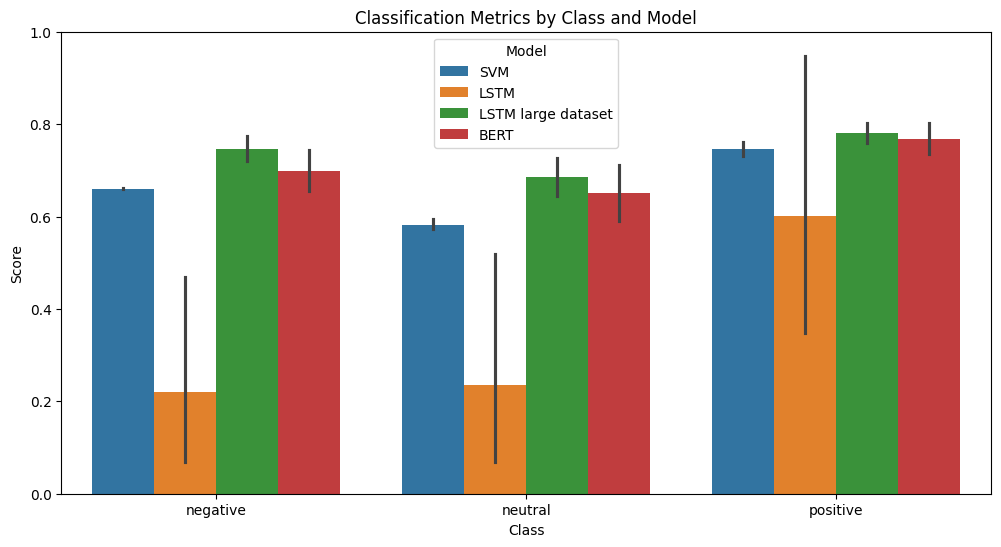

In [31]:
def report_to_df(report_dict, model_name):
    df = pd.DataFrame(report_dict).T
    df = df.loc[['negative', 'neutral', 'positive']]
    df = df[['precision', 'recall', 'f1-score']]
    df['Model'] = model_name
    df['Class'] = df.index
    return df.reset_index(drop=True)

svm_df = report_to_df(svm_report, "SVM")
lstm_df = report_to_df(lstm_report, "LSTM")
lstm2_df = report_to_df(lstm2_report, "LSTM large dataset")
bert_df = report_to_df(bert_report, "BERT")

combined_df = pd.concat([svm_df, lstm_df, lstm2_df, bert_df], ignore_index=True)

melted = combined_df.melt(id_vars=['Model', 'Class'],
                          value_vars=['precision', 'recall', 'f1-score'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Class', y='Score', hue='Model')
plt.title('Classification Metrics by Class and Model')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

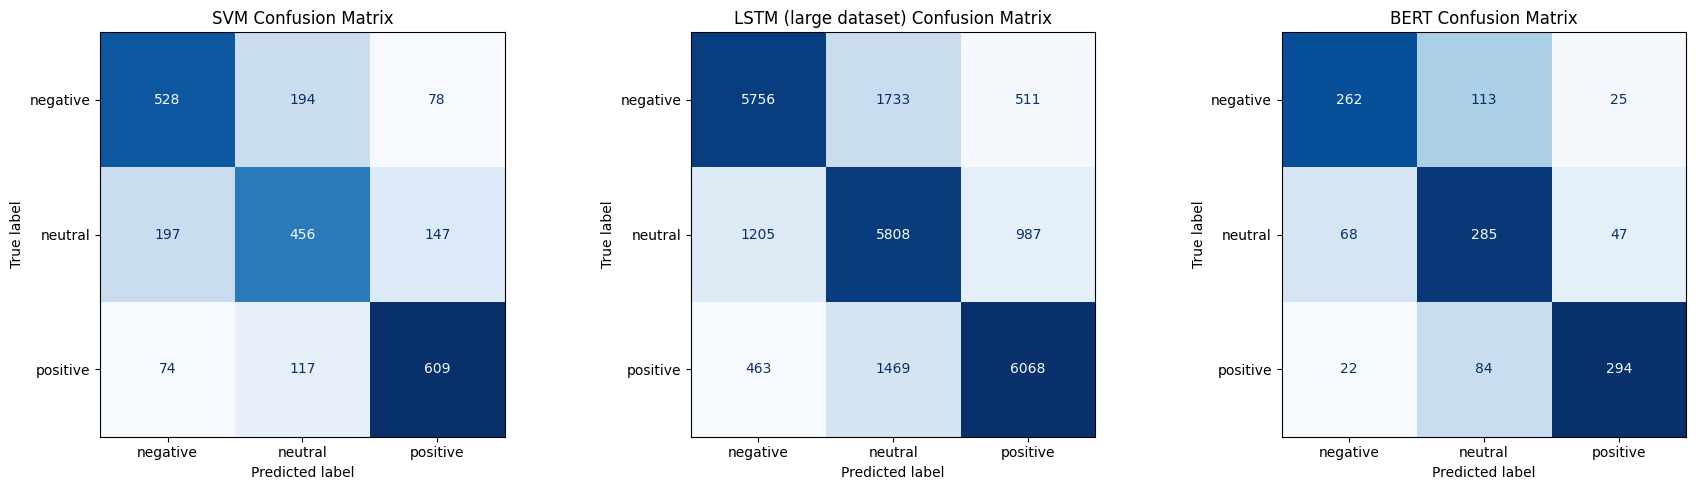

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

svm_cmd = ConfusionMatrixDisplay(svm_cm, display_labels=target_names)
svm_cmd.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('SVM Confusion Matrix')

lstm2_cmd = ConfusionMatrixDisplay(lstm2_cm, display_labels=target_names)
lstm2_cmd.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title('LSTM (large dataset) Confusion Matrix')

bert_cmd = ConfusionMatrixDisplay(bert_cm, display_labels=target_names)
bert_cmd.plot(ax=axes[2], cmap=plt.cm.Blues, colorbar=False)
axes[2].set_title('BERT Confusion Matrix')

plt.tight_layout()
plt.show()

## Conclusion / Discussion


#### SVM

- Performs decently across all three sentiment classes.
- Strongest on positive and negative sentiments (both >0.65).
- Slightly lower on neutral class (~0.58).
- Very low standard deviation (high consistency).

Based on the confusion matrices, solid and balanced but struggles a bit with neutral vs others.

#### LSTM (Small set)

- Subpar across the board.
- Negative and neutral class scores are very low (<0.3), positive is the best (~0.58) but with high variance.
- High standard deviation implies instability in performance.

#### BERT

- Outperforms LSTM in every category.
- Positive and negative sentiments are strong (~0.75 and ~0.69).
- Neutral still weaker (~0.62) but far better than LSTM.
- Moderate variance suggests some inconsistency but still robust.

Best classifier so far, handles class ambiguity well.

#### LSTM (Large set)

- Dramatic improvement: from 36% to ~73.5% accuracy
- Precision/recall/f1 across all classes now rivals or even outperforms BERT.
- Shows that LSTM models benefit greatly from more training data.
- Very stable generalization - validation and test accuracy stayed close, showing no overfitting.
- Slightly better on negative and positive classes than neutral, but not by a large margin.

Even though it used an order of magnitude more data than BERT (96,000 vs 9,600 reviews), compute time was about the same as BERT, and the memory footprint was 1/4 the size of BERT.

### Overall impressions

I originally wanted to keep the dataset size the same for all the models. I was constrained on resources for BERT so that was my upper-bound. However, when adding an order of magnitude more data to LSTM there was a dramatic improvement in accuracy. Before that, BERT is the clear winner in terms of accuracy and robustness. SVM is a solid baseline and performs surprisingly well given its simplicity.

### Discussion

I found this dataset to be really interesting and fun. There is still a lot that could be done with the data. Neutral is a challenge to get correct. All the models struggled with it. I guess the semantics of 3-star reviews is difficult to classify because there isn't anything polarizing about the product. It was one of the reasons I wanted to look into BERT. I thought leaning on a pre-trained model and using an approach that was bi-directional would pick up on subtler cues. But BERT might do better at neutral with more data. 

After seeing the dramatic improvements in LSTM with more data, it highlights how much deep learning models are data hungry.